# train a multinominal classifier

## load and process the data with gensim

In [1]:
import numpy as np
import gensim
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.punkt import PunktLanguageVars
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/chen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/chen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/chen/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
def preprocessing(text:str) -> str:
    pattern = re.compile(r"\w+\s*'\s*\w+") # Pattern to match ' with optional spaces before and after
    text = re.sub(pattern, lambda m: m.group().replace(" ", ""),text)
    stop_words = set(stopwords.words('french'))

    text = text.lower()

    french_tokenizer = PunktLanguageVars()
    tokens = word_tokenize(text, language='french')

    tokens = [token for token in tokens if token not in stop_words and token.isalnum()]

    return " ".join(tokens)

In [4]:
# Load all emotion CSV files
emotions = ['fear', 'love', 'disgust', 'surprise']
dataframes = []
for emotion in emotions:
    if emotion == "fear" or emotion == "surprise":
        df = pd.read_csv(f"../{emotion}.csv",usecols=["emotion","text"])
        df = df.rename(columns={
            'emotion': 'emotions',
            'text': 'excerpt'
        })
    else:
        df = pd.read_csv(f"../{emotion}.csv")
    dataframes.append(df)

# Concatenate all dataframes
data = pd.concat(dataframes, ignore_index=True)

# Create numeric labels for emotions
data['emotion'] = data['emotions'].map({
    'fear': 0,
    'love': 1, 
    'disgust': 2,
    'surprise': 3
})

# Apply preprocessing
data["excerpt_clean"] = data['excerpt'].apply(preprocessing)

In [6]:
X_train,X_test,y_train,y_test = train_test_split(data["excerpt_clean"],data["emotion"],test_size=0.2,stratify=data['emotion'])
X_train.head()

140     elles ciel ouvert disposées amas entourées fla...
2511    esprits morts attirés venti lateur fini prendr...
2156    ni reconnaître ni voir sentait toute case odeu...
380     vite vite ruche rit toujours faire miel rend b...
968     toutefois faut savoir cache souvent sous épais...
Name: excerpt_clean, dtype: object

## Word embedding with word2vec

In [15]:
w2v_model = gensim.models.Word2Vec(
    X_train,
    vector_size=100,
    window=10,
    min_count=2,
    workers=4,
    epochs=20
)

vocabulary = set(w2v_model.wv.index_to_key)

In [ ]:
def article2vec(expert, vocab, model):
    vectors = [model.wv[word] for word in expert if word in vocab]
    if len(vectors) > 0:
        return np.mean(vectors,axis=0) # simply taking the mean of vectors to build the vector representation of expert
    else:
        return np.zeros(model.vector_size) # if non, return a vector size length vector with 0
    
X_train_vect = np.array([article2vec(expert,vocabulary,w2v_model ) for expert in X_train])
X_test_vect = np.array([article2vec(expert,vocabulary,w2v_model ) for expert in X_test])

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect, y_train.values.ravel())
y_pred = rf_model.predict(X_test_vect)

Random Forest Classification Report:
              precision    recall  f1-score   support

        fear      0.581     0.367     0.450        98
        love      0.593     0.756     0.665       160
     disgust      0.763     0.844     0.801       160
    surprise      0.447     0.337     0.384       101

    accuracy                          0.628       519
   macro avg      0.596     0.576     0.575       519
weighted avg      0.615     0.628     0.612       519



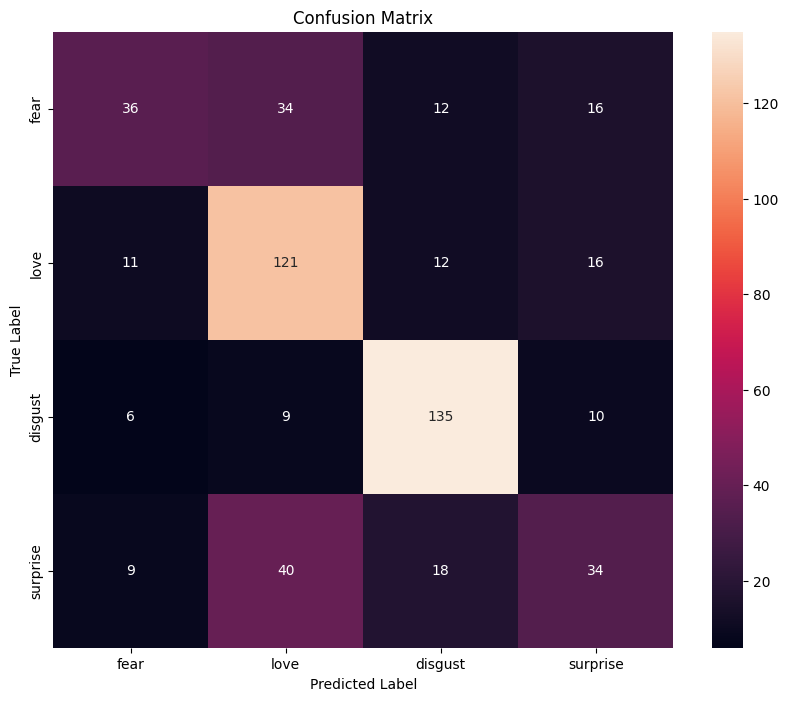


SVM Classification Report:
              precision    recall  f1-score   support

        fear      0.552     0.163     0.252        98
        love      0.654     0.425     0.515       160
     disgust      0.706     0.750     0.727       160
    surprise      0.301     0.644     0.410       101

    accuracy                          0.518       519
   macro avg      0.553     0.495     0.476       519
weighted avg      0.582     0.518     0.510       519



In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Print classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=emotions,
                          digits=3))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=emotions,
            yticklabels=emotions)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Try SVM classifier
svm = SVC(kernel="linear", class_weight="balanced")
svm.fit(X_train_vect, y_train)
y_pred_svm = svm.predict(X_test_vect)

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm,
                          target_names=emotions,
                          digits=3))

In [20]:
# Add these imports to your first code cell
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Add a new cell for improved preprocessing and model evaluation
# Scale features before training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vect)
X_test_scaled = scaler.transform(X_test_vect)

# Try KNN with different parameters
knn_params = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='f1_macro')
knn_grid.fit(X_train_scaled, y_train)

# Print KNN results
print("Best KNN parameters:", knn_grid.best_params_)
y_pred_knn = knn_grid.predict(X_test_scaled)

print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn,
                          target_names=emotions,
                          digits=3))

# Improve Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1_macro')
rf_grid.fit(X_train_scaled, y_train)

print("\nBest Random Forest parameters:", rf_grid.best_params_)
y_pred_rf = rf_grid.predict(X_test_scaled)



Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}

KNN Classification Report:
              precision    recall  f1-score   support

        fear      0.452     0.337     0.386        98
        love      0.587     0.506     0.544       160
     disgust      0.599     0.887     0.715       160
    surprise      0.324     0.228     0.267       101

    accuracy                          0.538       519
   macro avg      0.491     0.490     0.478       519
weighted avg      0.514     0.538     0.513       519



KeyboardInterrupt: 